**Importar las Librerias**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import MaxAbsScaler
import shap


In [3]:
df_contract = pd.read_csv('./contract.csv')
df_internet = pd.read_csv('./internet.csv')
df_personal = pd.read_csv('./personal.csv')
df_phone = pd.read_csv('phone.csv')

# Analisis Exploratorio de Datos (EDA)

In [4]:
df_contract.info()
df_contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
df_personal.info()
df_personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [7]:
df_phone.info()
df_phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**OBSERVACIONES:**Puedo notar que necesitare hacer una codificación para poder trabajar con las variables categoricas que tenemos, tambien realizare un merge para poder un solo conjunto de datos en donde pueda definir el target y separar las caracteristicas y eliminar aquellas columnas que sean inecesarias como "Begin_date", "Customer_id" entre otras.

# Preprocesamiento de Datos

In [8]:
# Agregar Nuestra Columna Target a Nuestro conjunto de Datos
df_contract['target'] = (~(df_contract['EndDate'] == 'No')).astype('int')

In [9]:
df_contract['target'].mean()

0.2653698707936959

**Observaciones:** Este valor nos comunica que aproximadamente el 26.54% de las personas observadas en nuestro conjunto de datos han cancelado su contrato. Esto es bueno para tomarlo en cuenta, ya que nos ayuda a saber que seria bueno tratar realizar un sobremuestreo para poder replicar mas los valores de no cancelaciones par apoder entrenar mejor a nuestro modelo, es decir debido a este 26 nos podemos dar una idea que tendremos una gran diferencia de 0 y 1, por lo tanto realizaremos un sobremuestreo que nos ayude a tener una cantidad similar de zeros y unos.

In [10]:
# Realizamos merges para poder tener nuestro conjunto de datos con el que trabajaremos
data_set = (
    df_contract.merge(df_personal, on ='customerID', how='left')
    .merge(df_phone, on='customerID', how='left')
    .merge(df_internet, on='customerID', how='left' )
)

In [11]:
# Visaulizaremos el tamaño de Nuestro conjunto de datos
data_set.shape

(7043, 21)

In [12]:
# Observaremos las columnas de nuestro Conjunto de Datos que acabamos de construir
data_set.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'target', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [13]:
# Visualizar los valores faltantes en nuestro conjunto de datos
data_set.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
target                 0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64

In [14]:
# Tratar de convertir cada elemento en un entero
for x in data_set['TotalCharges'][500]: 
    try:
        int(x)
    except: 
        print(f'error string: {repr(x)}')

error string: '.'


In [15]:
print(data_set['TotalCharges'])

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object


**Remplazar los valores NaN por 'No' para poder tener un conjunto de Datos con el que podamos trabajar nuestros modelos**

In [16]:
# Reemplazar valores ' ' con NaN en la columna TotalCharges
data_set['TotalCharges'] = data_set['TotalCharges'].replace(' ', float('nan'))

# Convertir la columna TotalCharges a tipo float64
data_set['TotalCharges'] = data_set['TotalCharges'].astype('float64')

# Reemplazar los valores NaN con 'No' en las columnas especificadas en cols_to_fill
cols_to_fill = [
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

for col in cols_to_fill:
    data_set[col] = data_set[col].fillna('No')

In [17]:
data_set['TotalCharges'] = data_set['TotalCharges'].fillna('No')

In [18]:
data_set.isnull().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

**Observaciones:** Excelente ahora ya tenemos un conjunto de datos limpio con el que podemos trabajar par desarollar nuestros modelos. Trabajamos con nuestros valores nulos para poder convertirlos de tal forma que pudieramos remplazar por no para poder utilizarlos en nuestros modelos, y podemos ver que ya no tenemos valores nulos en nuestro Conjunto de datos.

# Division de los Datos

In [19]:
# Eliminar Columnas innecesarias
data_set = data_set.drop(['BeginDate', 'EndDate', 'customerID', 'TotalCharges'], axis = 1)

In [38]:

# Inicializar el codificador OneHotEncoder
onehot_encoder = OneHotEncoder()

# Seleccionar columnas categóricas
categorical_columns = data_set.select_dtypes(include=['object']).columns.to_list()

# Codificar las columnas categóricas y convertirlas a un DataFrame
encoded_data = onehot_encoder.fit_transform(data_set[categorical_columns])
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Concatenar las columnas codificadas con el resto del DataFrame original
encoded_df = pd.concat([data_set.drop(columns=categorical_columns), encoded_df], axis=1)





# Definir nuestro objetivo y nuestras caracteristicas
target = encoded_df['target']
features = encoded_df.drop(['target'], axis = 1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=0.5, random_state=12345)



# Entrenamiento de Modelos

**Primero Crearemos un modelo dummy que nos ayude a poder ver la differencia de un modelo que funciona con simple aleatoriedad a modelos que funcionen mejor que la simple aleatoriedad. Y despues crearemos modelos con muestras con sobremuestreos y estandarizados.

In [43]:
# Inicializar el modelo constante
modelo_constante = DummyClassifier(strategy='constant', constant=1)

# Entrenar el modelo constante
modelo_constante.fit(features_train, target_train)

# Predecir las etiquetas en el conjunto de datos de prueba
y_pred = modelo_constante.predict(features_test)

# Calcular el puntaje F1
auc_constante = roc_auc_score(target_test, y_pred, average='weighted')
# Calcular el accuracy score
accuracy_constante = accuracy_score(target_test, y_pred)

print("Puntaje roc_auc del modelo constante:", auc_constante)
print("puntaje accuracy_score del modelo constante:", accuracy_constante)

Puntaje roc_auc del modelo constante: 0.5
puntaje accuracy_score del modelo constante: 0.27111426543647976


Claramente podemos ver como nuestro modelo dummy que funciona con aleatoriedad tiene resultados muy bajos al tener un 50 en roc_auc que es nuetra metrica principal y un 27 en exactitud. Valores que nos ayudaran a comparar que tan buenos son nuestros modelos en comparacion con la simple aleatoriedad.

In [39]:
# Modelo de Bosque Aleatorio
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {'n_estimators': [20, 40, 80],
                 'max_depth': [2, 4, 8],
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='roc_auc')
rf_grid_search.fit(features_train, target_train)

rf_auc_roc = roc_auc_score(target_test, rf_grid_search.predict_proba(features_test)[:, 1])
rf_accuracy = accuracy_score(target_test, rf_grid_search.predict(features_test))

# Mostrar los resultados
print("Random Forest:")
print("AUC-ROC:", rf_auc_roc)
print("Exactitud:", rf_accuracy)
print()

Random Forest:
AUC-ROC: 0.8322682850981611
Exactitud: 0.7750177430801988



In [23]:
# Modelo para Catboost
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_param_grid = {'n_estimators': [100, 200, 300],
                       'learning_rate': [0.05, 0.1, 0.2]}
catboost_grid_search = GridSearchCV(catboost_model, catboost_param_grid, cv=5, scoring='roc_auc')
catboost_grid_search.fit(features_train, target_train)

catboost_auc_roc = roc_auc_score(target_test, catboost_grid_search.predict_proba(features_test)[:, 1])
catboost_accuracy = accuracy_score(target_test, catboost_grid_search.predict(features_test))

print("CatBoost:")
print("AUC-ROC:", catboost_auc_roc)
print("Exactitud:", catboost_accuracy)
print()

CatBoost:
AUC-ROC: 0.8283186427198623
Exactitud: 0.7757274662881476



In [24]:
# Modelo de LightGBM
lgb_model = LGBMClassifier(random_state=42)
lgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.05, 0.1, 0.2]}
lgb_grid_search = GridSearchCV(lgb_model, lgb_param_grid, cv=5, scoring='roc_auc')
lgb_grid_search.fit(features_train, target_train)

lgb_auc_roc = roc_auc_score(target_test, lgb_grid_search.predict_proba(features_test)[:, 1])
lgb_accuracy = accuracy_score(target_test, lgb_grid_search.predict(features_test))

print("LightGBM:")
print("AUC-ROC:", lgb_auc_roc)
print("Exactitud:", lgb_accuracy)
print()

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 881, number of negative: 2499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 3380, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260651 -> initscore=-1.042588
[LightGBM] [Info] Start training from score -1.042588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [25]:
# Modelo de XGBoost
xgb_model = XGBClassifier(random_state=42, verbosity=0)
xgb_param_grid = {'n_estimators': [100, 200, 300],
                  'max_depth': [3, 5, 7],
                  'learning_rate': [0.05, 0.1, 0.2]}
xgb_grid_search = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='roc_auc')
xgb_grid_search.fit(features_train, target_train)

xgb_auc_roc = roc_auc_score(target_test, xgb_grid_search.predict_proba(features_test)[:, 1])
xgb_accuracy = accuracy_score(target_test, xgb_grid_search.predict(features_test))

print("XGBoost:")
print("AUC-ROC:", xgb_auc_roc)
print("Exactitud:", xgb_accuracy)

XGBoost:
AUC-ROC: 0.8301500838613968
Exactitud: 0.7799858055358411


**Observaciones:** De todos nuestros modelos que acabamos de entrenar logramos ver que el mejor es un RandomForestClassifier con un valor roc_auc de 0.83 el cual supera la metrica que nosotros tenemos establecida, sin embargo podemos mejorar estos resultados realizando un sobremuestreo, un escalamiento de datos y seleccionando los mejores parametros para nuestros modelos. Nuestra meta ahora sera alcanzar un roc_auc igual o superior a 0.88

# Hacer el oversampling

In [45]:
# Haremos un sobremuestreo para poder aumentar nuestra cantidad de unos
def upsample(features, target, repeat):
    features_zeros = pd.DataFrame(features[target == 0])
    features_ones = pd.DataFrame(features[target == 1])
    target_zeros = pd.Series(target[target == 0])
    target_ones = pd.Series(target[target == 1])
    X_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    y_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    X_upsampled, y_upsampled = shuffle(
        X_upsampled, y_upsampled, random_state=12345
    )

    return X_upsampled, y_upsampled

In [46]:
# Repitiremos nuestros unos 3 veces que es el numero que nos permite tener una cantidad muy similar de zeros y unos.
features_train_upsampled, target_train_upsampled = upsample(
    features_train, target_train, 3
)
print(target_train_upsampled.value_counts())

target
1    3303
0    3124
Name: count, dtype: int64


# Modelo RandomForest Classifier con sobremuestreo

In [47]:


# Columnas numéricas y categóricas
columnas_numericas = features_train.select_dtypes(include=['int', 'float']).columns
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
    ])

# Pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestClassifier())])  

# Definir los datos
y = data_set['target']
X = data_set.drop(['target'], axis=1)

# Definir la cuadrícula de parámetros a buscar
param_grid = {
    'regressor__n_estimators': [20, 40, 80],  # Número de árboles en el bosque
    'regressor__max_depth': [2, 4, 8],  # Profundidad máxima de los árboles
}

# Realizar búsqueda de cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
inicio_busqueda = time.time()
grid_search.fit(features_train_upsampled, target_train_upsampled)
fin_busqueda = time.time()
tiempo_busqueda = fin_busqueda - inicio_busqueda

# Obtener el mejor modelo
best_pipeline = grid_search.best_estimator_

# Medir tiempo de predicción
inicio_prediccion = time.time()
y_pred = best_pipeline.predict(features_test)
fin_prediccion = time.time()
tiempo_prediccion = fin_prediccion - inicio_prediccion

# Calcular el accuracy score
accuracy_best_model = accuracy_score(target_test, y_pred)

# Imprimir los mejores parámetros y las métricas
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("roc_auc del mejor modelo:", grid_search.best_score_) 
print("Accuracy score del mejor modelo:", accuracy_best_model)

print("Tiempo de búsqueda de cuadrícula:", tiempo_busqueda, "segundos")
print("Velocidad de predicción:", tiempo_prediccion / len(target_test), "segundos por instancia")

Mejores parámetros encontrados: {'regressor__max_depth': 8, 'regressor__n_estimators': 80}
roc_auc del mejor modelo: 0.8674529447647661
Accuracy score del mejor modelo: 0.7260468417317246
Tiempo de búsqueda de cuadrícula: 8.070939540863037 segundos
Velocidad de predicción: 1.924675859569065e-05 segundos por instancia


# Modelo LGBMClassifier con SobreMuestreo

In [49]:
# Columnas numéricas y categóricas
columnas_numericas = features_train.select_dtypes(include=['int', 'float']).columns
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

# Preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
    ])

# Pipeline con preprocesamiento y LGBMClassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LGBMClassifier())])

# Definir la cuadrícula de parámetros a buscar
param_grid = {
    'classifier__n_estimators': [20, 40, 80],  # Número de árboles en el bosque
    'classifier__max_depth': [2, 4, 8],  # Profundidad máxima de los árboles
}

# Realizar búsqueda de cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
inicio_busqueda = time.time()
grid_search.fit(features_train_upsampled, target_train_upsampled)
fin_busqueda = time.time()
tiempo_busqueda = fin_busqueda - inicio_busqueda

# Obtener el mejor modelo
best_pipeline = grid_search.best_estimator_

# Medir tiempo de predicción
inicio_prediccion = time.time()
y_pred = best_pipeline.predict(features_test)
fin_prediccion = time.time()
tiempo_prediccion = fin_prediccion - inicio_prediccion

# Calcular el accuracy score
accuracy_best_model = accuracy_score(target_test, y_pred)

# Imprimir los mejores parámetros y las métricas
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("AUC-ROC del mejor modelo:", grid_search.best_score_) 
print("Accuracy score del mejor modelo:", accuracy_best_model)

print("Tiempo de búsqueda de cuadrícula:", tiempo_busqueda, "segundos")
print("Velocidad de predicción:", tiempo_prediccion / len(target_test), "segundos por instancia")

[LightGBM] [Info] Number of positive: 2642, number of negative: 2499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 5141, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513908 -> initscore=0.055646
[LightGBM] [Info] Start training from score 0.055646
[LightGBM] [Info] Number of positive: 2642, number of negative: 2499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 5141, number of used features: 34
[LightGBM] [Info] [binary:Bo

# Modelo Catboost con SobreMuestreo

In [50]:
# Columnas numéricas y categóricas
columnas_numericas = features_train.select_dtypes(include=['int', 'float']).columns
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

# Preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
    ])

# Pipeline con preprocesamiento y CatBoostClassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', CatBoostClassifier())])

# Definir la cuadrícula de parámetros a buscar
param_grid = {
    'classifier__iterations': [100, 200, 300],  # Número de iteraciones
    'classifier__depth': [4, 6, 8],  # Profundidad del árbol
}

# Realizar búsqueda de cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
inicio_busqueda = time.time()
grid_search.fit(features_train_upsampled, target_train_upsampled)
fin_busqueda = time.time()
tiempo_busqueda = fin_busqueda - inicio_busqueda

# Obtener el mejor modelo
best_pipeline = grid_search.best_estimator_

# Medir tiempo de predicción
inicio_prediccion = time.time()
y_pred = best_pipeline.predict(features_test)
fin_prediccion = time.time()
tiempo_prediccion = fin_prediccion - inicio_prediccion

# Calcular el accuracy score
accuracy_best_model = accuracy_score(target_test, y_pred)

# Imprimir los mejores parámetros y las métricas
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("AUC-ROC del mejor modelo:", grid_search.best_score_) 
print("Accuracy score del mejor modelo:", accuracy_best_model)

print("Tiempo de búsqueda de cuadrícula:", tiempo_busqueda, "segundos")
print("Velocidad de predicción:", tiempo_prediccion / len(target_test), "segundos por instancia")

Learning rate set to 0.171219
0:	learn: 0.6336875	total: 2.56ms	remaining: 254ms
1:	learn: 0.5902930	total: 5.04ms	remaining: 247ms
2:	learn: 0.5655298	total: 7.29ms	remaining: 236ms
3:	learn: 0.5461668	total: 9.38ms	remaining: 225ms
4:	learn: 0.5325478	total: 11.3ms	remaining: 215ms
5:	learn: 0.5223544	total: 13.7ms	remaining: 215ms
6:	learn: 0.5154873	total: 15.8ms	remaining: 210ms
7:	learn: 0.5095158	total: 18.1ms	remaining: 208ms
8:	learn: 0.5049412	total: 20.2ms	remaining: 205ms
9:	learn: 0.5005248	total: 22.5ms	remaining: 202ms
10:	learn: 0.4966079	total: 25.3ms	remaining: 205ms
11:	learn: 0.4941814	total: 27.3ms	remaining: 201ms
12:	learn: 0.4915673	total: 29.8ms	remaining: 199ms
13:	learn: 0.4895922	total: 32ms	remaining: 196ms
14:	learn: 0.4875812	total: 34.2ms	remaining: 194ms
15:	learn: 0.4855528	total: 36.5ms	remaining: 191ms
16:	learn: 0.4837065	total: 38.6ms	remaining: 188ms
17:	learn: 0.4822342	total: 40.8ms	remaining: 186ms
18:	learn: 0.4810854	total: 43.2ms	remaining: 

# Modelo XGBClassifier con SobreMuestreo

In [51]:
# Columnas numéricas y categóricas
columnas_numericas = features_train.select_dtypes(include=['int', 'float']).columns
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

# Preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
    ])

# Pipeline con preprocesamiento y XGBClassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier())])

# Definir la cuadrícula de parámetros a buscar
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Número de estimadores (árboles)
    'classifier__max_depth': [3, 5, 7],  # Profundidad máxima del árbol
    'classifier__learning_rate': [0.05, 0.1, 0.2]  # Tasa de aprendizaje
}

# Realizar búsqueda de cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
inicio_busqueda = time.time()
grid_search.fit(features_train_upsampled, target_train_upsampled)
fin_busqueda = time.time()
tiempo_busqueda = fin_busqueda - inicio_busqueda

# Obtener el mejor modelo
best_pipeline = grid_search.best_estimator_

# Medir tiempo de predicción
inicio_prediccion = time.time()
y_pred = best_pipeline.predict(features_test)
fin_prediccion = time.time()
tiempo_prediccion = fin_prediccion - inicio_prediccion

# Calcular el accuracy score
accuracy_best_model = accuracy_score(target_test, y_pred)

# Imprimir los mejores parámetros y las métricas
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("AUC-ROC del mejor modelo:", grid_search.best_score_) 
print("Accuracy score del mejor modelo:", accuracy_best_model)

print("Tiempo de búsqueda de cuadrícula:", tiempo_busqueda, "segundos")
print("Velocidad de predicción:", tiempo_prediccion / len(target_test), "segundos por instancia")

Mejores parámetros encontrados: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300}
AUC-ROC del mejor modelo: 0.9252820460487572
Accuracy score del mejor modelo: 0.7423704755145494
Tiempo de búsqueda de cuadrícula: 35.44808483123779 segundos
Velocidad de predicción: 5.767902133310831e-06 segundos por instancia


**Observaciones:** De todos nuestros modelos podemos observar claramente que nuestro mejor modelo con calificacion roc_auc es nuestreo modelo XGBClassifier con un valor roc_auc muy bueno de 0.925 que supera por mucho nuestra meta establecida de 0.88. 2 de nuestros modelos no alcanzaron nuestra meta los cuales son el modelo de `RandomForestClassifier` y `LGBMClassifier`.

# Los 3 Mejores Modelos con el conjunto de validacion

**El mejor Modelo (XGBoost Classifier) con el conjunto de validacion**

In [54]:
# Numero Uno Mejor Modelo Ahora con el conjunto de Validación

# Columnas numéricas y categóricas
columnas_numericas = features_train.select_dtypes(include=['int', 'float']).columns
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

# Preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
    ])

# Pipeline con preprocesamiento y XGBClassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', XGBClassifier())])

# Definir la cuadrícula de parámetros a buscar
param_grid = {
    'classifier__n_estimators': [100, 200, 300],  # Número de estimadores (árboles)
    'classifier__max_depth': [3, 5, 7],  # Profundidad máxima del árbol
    'classifier__learning_rate': [0.05, 0.1, 0.2]  # Tasa de aprendizaje
}

# Realizar búsqueda de cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
inicio_busqueda = time.time()
grid_search.fit(features_train_upsampled, target_train_upsampled)
fin_busqueda = time.time()
tiempo_busqueda = fin_busqueda - inicio_busqueda

# Obtener el mejor modelo
best_pipeline = grid_search.best_estimator_

# Medir tiempo de predicción
inicio_prediccion = time.time()
y_pred = best_pipeline.predict(features_valid)
fin_prediccion = time.time()
tiempo_prediccion = fin_prediccion - inicio_prediccion

# Calcular el accuracy score
accuracy_best_model = accuracy_score(target_valid, y_pred)

# Imprimir los mejores parámetros y el AUC-ROC
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("AUC-ROC del mejor modelo:", grid_search.best_score_) 
print("accuracy del mejor modelo:", accuracy_best_model)

print("Tiempo de búsqueda de cuadrícula:", tiempo_busqueda, "segundos")
print("Velocidad de predicción:", tiempo_prediccion / len(target_test), "segundos por instancia")

mejor_modelo_XGBClassifier = best_pipeline

Mejores parámetros encontrados: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300}
AUC-ROC del mejor modelo: 0.9252820460487572
accuracy del mejor modelo: 0.7061745919091554
Tiempo de búsqueda de cuadrícula: 23.943020820617676 segundos
Velocidad de predicción: 3.5581730882524174e-06 segundos por instancia


**El Segundo mejor Modelo (CatBoostClassifier) con el Conjunto de Validacion**

In [55]:
# Columnas numéricas y categóricas
columnas_numericas = features_train.select_dtypes(include=['int', 'float']).columns
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

# Preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
    ])

# Pipeline con preprocesamiento y CatBoostClassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', CatBoostClassifier())])

# Definir la cuadrícula de parámetros a buscar
param_grid = {
    'classifier__iterations': [100, 200, 300],  # Número de iteraciones
    'classifier__depth': [4, 6, 8],  # Profundidad del árbol
}

# Realizar búsqueda de cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
inicio_busqueda = time.time()
grid_search.fit(features_train_upsampled, target_train_upsampled)
fin_busqueda = time.time()
tiempo_busqueda = fin_busqueda - inicio_busqueda

# Obtener el mejor modelo
best_pipeline = grid_search.best_estimator_

# Medir tiempo de predicción
inicio_prediccion = time.time()
y_pred = best_pipeline.predict(features_valid)
fin_prediccion = time.time()
tiempo_prediccion = fin_prediccion - inicio_prediccion

# Calcular el accuracy score
accuracy_best_model = accuracy_score(target_valid, y_pred)

# Imprimir los mejores parámetros y el AUC-ROC
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("AUC-ROC del mejor modelo:", grid_search.best_score_) 
print("accuracy del mejor modelo:", accuracy_best_model)

print("Tiempo de búsqueda de cuadrícula:", tiempo_busqueda, "segundos")
print("Velocidad de predicción:", tiempo_prediccion / len(target_test), "segundos por instancia")

Learning rate set to 0.171219
0:	learn: 0.6336875	total: 2.33ms	remaining: 231ms
1:	learn: 0.5902930	total: 4.39ms	remaining: 215ms
2:	learn: 0.5655298	total: 6.77ms	remaining: 219ms
3:	learn: 0.5461668	total: 9.06ms	remaining: 217ms
4:	learn: 0.5325478	total: 11.2ms	remaining: 212ms
5:	learn: 0.5223544	total: 13.3ms	remaining: 209ms
6:	learn: 0.5154873	total: 15.4ms	remaining: 205ms
7:	learn: 0.5095158	total: 17.5ms	remaining: 201ms
8:	learn: 0.5049412	total: 19.7ms	remaining: 199ms
9:	learn: 0.5005248	total: 22.1ms	remaining: 198ms
10:	learn: 0.4966079	total: 24.4ms	remaining: 198ms
11:	learn: 0.4941814	total: 26.7ms	remaining: 196ms
12:	learn: 0.4915673	total: 29.2ms	remaining: 195ms
13:	learn: 0.4895922	total: 31.5ms	remaining: 194ms
14:	learn: 0.4875812	total: 33.9ms	remaining: 192ms
15:	learn: 0.4855528	total: 36.1ms	remaining: 189ms
16:	learn: 0.4837065	total: 38ms	remaining: 186ms
17:	learn: 0.4822342	total: 40.5ms	remaining: 184ms
18:	learn: 0.4810854	total: 42.4ms	remaining: 

**El Tercer mejor Modelo (LGBMClassifier) con el conjunto de validacion**

In [56]:
# Columnas numéricas y categóricas
columnas_numericas = features_train.select_dtypes(include=['int', 'float']).columns
columnas_categoricas = features_train.select_dtypes(include=['object']).columns

# Preprocesamiento de datos
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),
    ])

# Pipeline con preprocesamiento y LGBMClassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LGBMClassifier())])

# Definir la cuadrícula de parámetros a buscar
param_grid = {
    'classifier__n_estimators': [20, 40, 80],  # Número de árboles en el bosque
    'classifier__max_depth': [2, 4, 8],  # Profundidad máxima de los árboles
}

# Realizar búsqueda de cuadrícula
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
inicio_busqueda = time.time()
grid_search.fit(features_train_upsampled, target_train_upsampled)
fin_busqueda = time.time()
tiempo_busqueda = fin_busqueda - inicio_busqueda

# Obtener el mejor modelo
best_pipeline = grid_search.best_estimator_

# Medir tiempo de predicción
inicio_prediccion = time.time()
y_pred = best_pipeline.predict(features_valid)
fin_prediccion = time.time()
tiempo_prediccion = fin_prediccion - inicio_prediccion

# Calcular el accuracy score
accuracy_best_model = accuracy_score(target_valid, y_pred)

# Imprimir los mejores parámetros y el AUC-ROC
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("AUC-ROC del mejor modelo:", grid_search.best_score_) 
print("accuracy del mejor modelo:", accuracy_best_model)

print("Tiempo de búsqueda de cuadrícula:", tiempo_busqueda, "segundos")
print("Velocidad de predicción:", tiempo_prediccion / len(target_test), "segundos por instancia")

[LightGBM] [Info] Number of positive: 2642, number of negative: 2499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 5141, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513908 -> initscore=0.055646
[LightGBM] [Info] Start training from score 0.055646
[LightGBM] [Info] Number of positive: 2642, number of negative: 2499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 5141, number of used features: 34
[LightGBM] [Info] [binary:Bo

# Conclusiones de los modelos

### Crearemos una tabla que demuestre el rendimiento de nuestros tres mejores modelos

In [65]:
# Definir los resultados de prueba y entrenamiento de cada modelo
resultados = {
    'Modelo': ['XGBoost','CatBoost','LightGBM'],
    'Roc_auc Testeo':[0.925, 0.913, 0.871],  # RMSE obtenido en prueba para cada modelo
    'Accuracy Testeo':[0.706, 0.722, 0.717],
    'Tiempo de Predicción (s)': [3.56, 0, 1.77],  # Tiempo de predicción promedio por instancia en segundos
    'Tiempo de Entrenamiento (s)': [23.94, 38.21, 2.45]  # Tiempo de entrenamiento en segundos para cada modelo
}

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

# Mostrar la tabla
display(df_resultados)

,Modelo,Roc_auc Testeo,Accuracy Testeo,Tiempo de Predicción (s),Tiempo de Entrenamiento (s)
0,XGBoost,0.925,0.706,3.56,23.94
1,CatBoost,0.913,0.722,0.00,38.21
2,LightGBM,0.871,0.717,1.77,2.45


**Observaciones:** De esta tabla que acabamos de crear podemos destacar que nuestro modelo con un mejor Accuracy que es nuetra meta principal es nuestro modelo `XGBoost` con un '0.925' aunque tiene una prediccion mas lenta, no resulta como un gran inconveniente ya que la espera no es mas de 4 segundos. Por otro lado si nosotros nos enfocaramos mas en la rapidez tras haber superado nuestra metrica de 0.75 podrias optar por LightGBM por que es muy rapido en comparacion con los otros modelos, pero como en este caso hemos optado por tener un modelo con el mejor rendiminento en nuestra metrica de roc_auc, nos quedaremos con nuestro modelo XGBoostClassifier.

# Conclusiones de las Caracteristicas

**Preparar resultados para utilizar Shap**

In [66]:
# Crear el modelo con los parámetros obtenidos
mejor_modelo = XGBClassifier(n_estimators=300, max_depth=7, learning_rate=0.2)

# Entrenar el modelo con los datos de entrenamiento balanceados
mejor_modelo.fit(features_train, target_train)

# Predecir con el conjunto de prueba para utilizar Shap
y_pred = mejor_modelo.predict(features_test)

 99%|===================| 6363/6427 [02:16<00:01]        

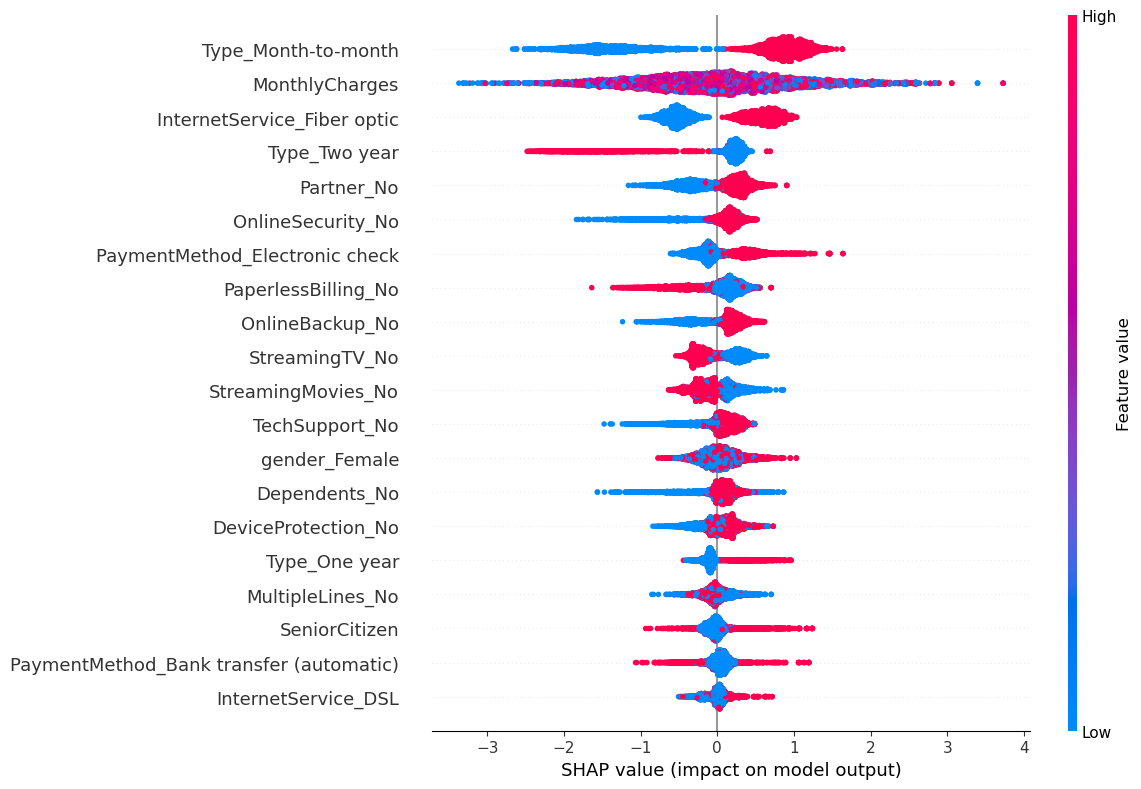

In [67]:
# Calcular las importancias de las características con SHAP
explainer = shap.Explainer(mejor_modelo, features_train_upsampled)
shap_values = explainer.shap_values(features_train_upsampled)

# Resumen de las importancias de las características
shap.summary_plot(shap_values, features_train_upsampled, plot_size=(12,8))

**Observaciones:** Para explicar lo que expresa este grafico tenemos que ver que como el grafico lo hace notar, el hecho de que tengamos valores rojos represtan los valores altos que tenemos en esa caracteristica, si estan en azul representan valores bajos. El hecho de que los valores esten del lado derecho de la linea negra que corre verticalmente el 0 significa que esta aumentanto la probabilidad de cancelacion. Teniendo eso en cuenta voy a dar mis sugerencias de las medidas que se pueden tomar en cuenta para disminuir la taza de cancelacion de contratos.

Claramente podemos ver que la Caracteristica que influye mas en comparacion de las demas en las cancelaciones de contratos es el plazo de pago, en este grafico podemos visualizar que aquellos que suelen tener un plazo de pago de mes por mes  o de año en año suelen cancelar mucho pero podemos ver muy claramente que aquellas personas que tienen un plazo de pago de 2 años tienen una taza muy baja de cancelacion. 

Por lo tanto seria muy bueno considerar hallar la forma de como convencer que las personas adquierean planes de dos años, ya sea por medio de dar promociones a personas con paquetes de plazo de pagos de mes y de año a plazos de dos años. Es muy probable que por el hecho de pagar plazos de tiempo mas grandes las personas opten por quedarse con los servicios de la empresa por que ya tienen asegurado servicio por 2 años, en lugar de alguien que tiene por solo un mes le puede resultar muy facil dejar los contractos con la empresa de Telecom e irse a otra empresa que de servicios similares.

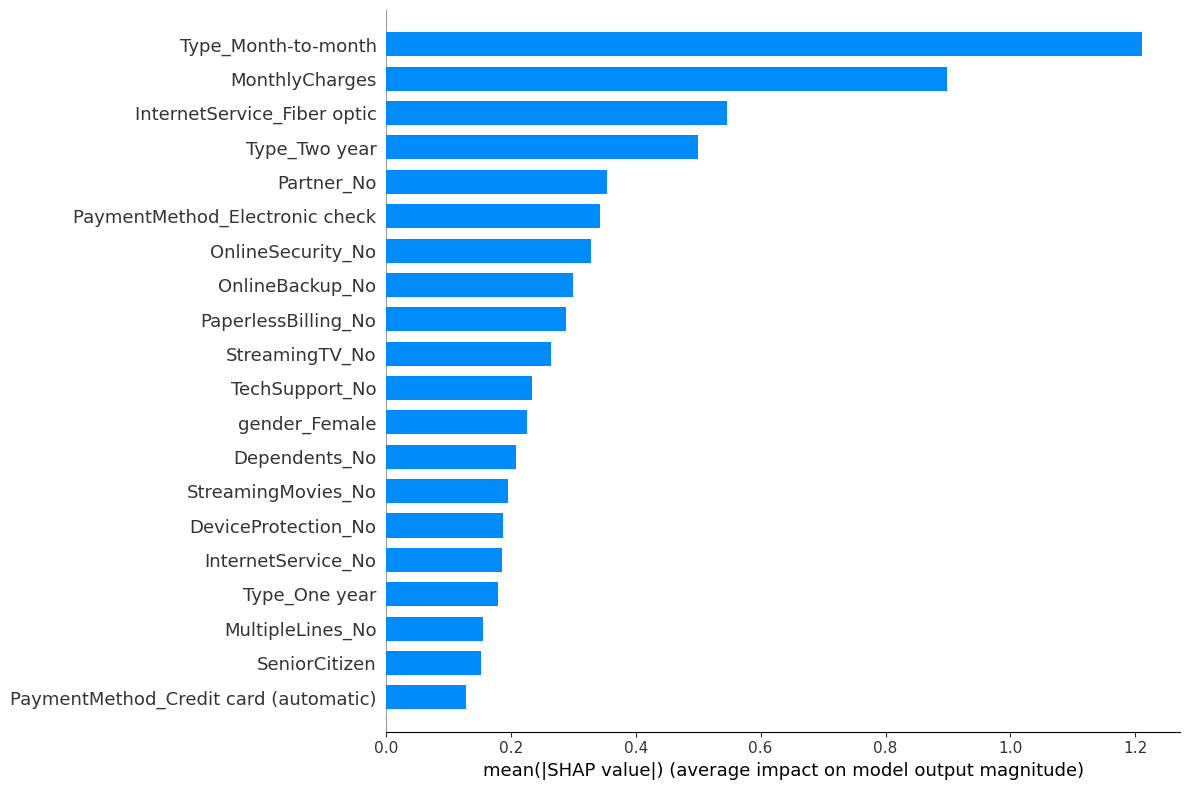

In [60]:
shap.summary_plot(shap_values,features_train_upsampled, plot_type='bar', plot_size=(12,8))


**Observaviones:** En este grafico de barras confirma lo que acabamos de decir al mostrarnos que la caracteristica que principalmente influye en si un cliente cancela o no es el plazo de pago de dos meses. Esto se puede deber a varias razones como el hecho de que la empresa se ha enfocado mas en encontrar nuevos clientes y quizas lo logra por medio de dar promociones en paquetes de mes por mes, seria mejor enfocarnos en poder retener mas clientes al ofrecerles plazos de dos años y a la vez tambien hallar nuevos clientes pero que sean atraidos por paquetes de plazo de dos años y no de mes en mes.

# Reflexiones Finales

1. Nuestro mejor modelo es un `XGBoost Classifier con un valor roc_auc de aproximadamente: '0.925' logrando haber superado nuestra meta inicial.
2. En este proyecto logramos notar desde un inicio que se nos proporciono un conjunto de datos que nos daba muy poca informacion sobre aquellos tipos de clientes que cancelaban por lo cual nos ayudo a saber que para mejorar los resultados de nuestros modelos seria bueno hacer un sobremuestreo, notamos claramente como esto ayudo a elevar la calificacion roc_auc de nuestros modelos.
3. Con base al analisis realizado mi sugerencia para bajar la taza de cancelacion de los contratos es hacer que los clientes que ya tiene la empresa que obtengan el plan de plazo de 2 años y que si la empresa busca nuevos clientes trate de hacer el esfuerzo para tambien atraerlos con plazos de 2 años, lo cual ayudara significativamente a bajar la taza de cancelacion de los contratos.

Gracias 